# CS613 Final Project: Cross-Language Image Classification 

In [48]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

## Preprocessing

In [56]:
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')
    
def load_cifar10(file_path):
    train_data, train_labels = [] , []
    for i in range(1,6):
        batch = unpickle(f"{file_path}\\data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"{file_path}\\test_batch")
    test_data = np.array(test_batch[b'data'])
    test_labels = np.array(test_batch[b'labels'])

    # Reshape the data to (N, 32, 32, 3)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return train_data, train_labels, test_data, test_labels

# Save data to CSV
def save_to_csv(data, labels, file_path):
    # Combine labels and data
    combined = np.column_stack((labels, data))
    np.savetxt(file_path, combined, delimiter=",", fmt="%f")
    print(f"Saved {file_path} successfully!")
    
# Prepare data
def normalize_images(data):
    return data / 255.0

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size),labels] = 1
    return one_hot

In [57]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
file_path = r"cifar-10-python\\cifar-10-batches-py"
x_train, y_train, x_test, y_test = load_cifar10(file_path)

# Preprocess data
print("Preprocessing data...")
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0],-1)

Loading CIFAR-10 dataset...
Preprocessing data...


In [58]:
# Save csv files if needed
print("Saving to CSV...")
save_to_csv(x_train, y_train, "train.csv")
save_to_csv(x_test, y_test, "test.csv")
print("CSV files created.")

Saving to CSV...
Saved train.csv successfully!
Saved test.csv successfully!
CSV files created.


In [59]:
# Preprocess data
# Normalize data
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

# Convert labels to one-hot encoding
num_classes = 10
y_train = one_hot_encode(y_train, num_classes)
y_test = one_hot_encode(y_test, num_classes)

# Add biases to X
X_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]

## Evaluation Functions

In [60]:
# Model Evaluation
def confusion_matrix(y_true, y_pred):
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_true_indices = np.argmax(y_true, axis=1)
    for t, p in zip(y_true_indices, y_pred):
        cm[t, p] += 1
    return cm

def accuracy(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)  #Converting one-hot encoded back to label encoded
    return np.sum(y_true_label == y_pred) / len(y_true_label)


def precision(cm):
    precisions = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp > 0:
            precisions.append(tp / (tp + fp))
        else:
            precisions.append(0)
    return np.mean(precisions)

def recall(cm):
    recalls = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn > 0:
            recalls.append(tp / (tp + fn))
        else:
            recalls.append(0)
    return np.mean(recalls)

def f1_score(cm):
    precisions = precision(cm)
    recalls = recall(cm)
    if (precisions + recalls) > 0:
        return 2 * (precisions * recalls) / (precisions + recalls) 
    else:
        return 0

## Logistic Regression Implementation

In [63]:
class logistic_regression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

        #Weight Initalization
        self.num_features = None
        self.num_classes = None
        self.weights = None

        # Initialize lists for tracking losses
        self.train_losses = []
        self.test_losses = []

    # Logistic Regression Functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predictProb(self, X):
        y_pred = self.softmax(np.dot(X, self.weights))
        return y_pred
    
    def predict(self, y_pred):
        return np.argmax(self.predictProb(y_pred), axis=1)

    def log_loss(self, y, y_pred, epsilon=1e-15):
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    
    def categorical_crossentropy(self, y, y_pred, epsilon=1e-15):
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def gradient_descent(self, X, y, weights, lr):
        y_pred = self.softmax(np.dot(X, weights))
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        return weights - lr * gradient

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        # Normalize data
        self.num_features = X_train.shape[1]
        self.num_classes = y_train.shape[1]
        self.weights = np.random.normal(loc=0.0, scale=1.0, size=(self.num_features, num_classes)) * 0.01
    
        for epoch in range(self.epochs):
            # Update Weights
            self.weights = self.gradient_descent(X_train, y_train, self.weights, self.learning_rate)

            train_pred = self.softmax(np.dot(X_train, self.weights))
            train_loss = self.categorical_crossentropy(y_train, train_pred)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = self.softmax(np.dot(X_test, self.weights))
                test_loss = self.categorical_crossentropy(y_test, test_pred)
                self.test_losses.append(test_loss)
            else:
                test_loss = None

            # if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{self.epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

In [64]:
lr = logistic_regression(learning_rate=0.01, epochs=500)

# Start timer
start_time = time.time()

# Fit the LR model
lr.fit(X_train, y_train, X_test, y_test)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")


Epoch 1/500: Train Loss = 2.2908, Test Loss = 2.2914
Epoch 2/500: Train Loss = 2.2800, Test Loss = 2.2803
Epoch 3/500: Train Loss = 2.2723, Test Loss = 2.2725
Epoch 4/500: Train Loss = 2.2651, Test Loss = 2.2654
Epoch 5/500: Train Loss = 2.2581, Test Loss = 2.2584
Epoch 6/500: Train Loss = 2.2513, Test Loss = 2.2517
Epoch 7/500: Train Loss = 2.2448, Test Loss = 2.2453
Epoch 8/500: Train Loss = 2.2385, Test Loss = 2.2390
Epoch 9/500: Train Loss = 2.2324, Test Loss = 2.2329
Epoch 10/500: Train Loss = 2.2265, Test Loss = 2.2270
Epoch 11/500: Train Loss = 2.2207, Test Loss = 2.2213
Epoch 12/500: Train Loss = 2.2152, Test Loss = 2.2158
Epoch 13/500: Train Loss = 2.2098, Test Loss = 2.2105
Epoch 14/500: Train Loss = 2.2045, Test Loss = 2.2053
Epoch 15/500: Train Loss = 2.1995, Test Loss = 2.2002
Epoch 16/500: Train Loss = 2.1946, Test Loss = 2.1953
Epoch 17/500: Train Loss = 2.1898, Test Loss = 2.1906
Epoch 18/500: Train Loss = 2.1851, Test Loss = 2.1860
Epoch 19/500: Train Loss = 2.1806, Te

In [67]:
# Generate predictions for train and test sets
train_pred = lr.predict(X_train)

# Calculate training metrics
train_cm = confusion_matrix(y_train, train_pred)
train_accuracy = accuracy(y_train, train_pred)
train_precision = precision(train_cm)
train_recall = recall(train_cm)
train_f1 = f1_score(train_cm)

# Print Metrics
print("\nTraining Evaluation:")
print("Confusion Matrix:\n", train_cm)
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


test_pred = lr.predict(X_test)

test_cm = confusion_matrix(y_test, test_pred)
test_accuracy = accuracy(y_test, test_pred)
test_precision = precision(test_cm)
test_recall = recall(test_cm)
test_f1 = f1_score(test_cm)

print("\nValidation Evaluation:")
print("Confusion Matrix:\n", test_cm)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Training Evaluation:
Confusion Matrix:
 [[2273  317  169  144   91  144  148  268 1023  423]
 [ 324 1916   78  150  126  277  304  192  625 1008]
 [ 672  222 1060  294  628  512  809  359  293  151]
 [ 275  310  420  989  205 1220  643  317  286  335]
 [ 397  176  580  246 1364  527  891  458  177  184]
 [ 196  224  472  654  267 1877  543  341  250  176]
 [ 119  244  324  442  412  599 2252  264  135  209]
 [ 254  264  302  270  613  433  424 1714  217  509]
 [ 823  433   71   87   25  277   43   83 2584  574]
 [ 350  796   65  106   71  159  203  206  666 2378]]
Accuracy: 0.3681
Precision: 0.3633
Recall: 0.3681
F1 Score: 0.3657

Validation Evaluation:
Confusion Matrix:
 [[468  52  48  30  10  22  28  52 215  75]
 [ 73 392  15  34  22  64  66  33 133 168]
 [143  40 213  73 132 102 157  55  60  25]
 [ 54  70  93 200  38 248 113  71  51  62]
 [ 69  29 124  62 248 101 206  86  41  34]
 [ 32  35 108 120  55 371 120  76  61  22]
 [ 20  46  81  82  72 114 461  44  31  49]
 [ 53  59  66  50

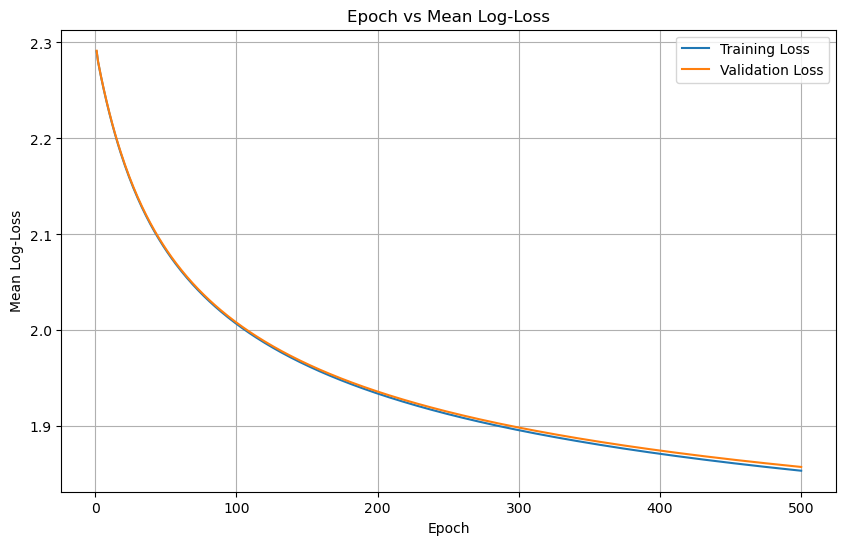

In [68]:
# Plot epoch vs log-loss
epochs = list(range(1, len(lr.train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr.train_losses, label='Training Loss')
plt.plot(epochs, lr.test_losses, label='Validation Loss')

plt.title('Epoch vs Mean Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Log-Loss')
plt.grid(True)
plt.legend()
plt.show()

## SVM Implementation

In [69]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_epochs=10):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs
        self.weights = None
        self.accuracy_per_epoch = []

    def fit(self, X, y, num_classes, x_test = None, y_test = None):
        _, n_features = X.shape
        self.weights = np.zeros((num_classes, n_features))
        for epoch in range(self.n_epochs):
            for c in range(num_classes):
                y_binary = np.where(y == c, 1, -1)
                w = self.weights[c,:]
                
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, w)) # Check if current sample passes margin condition
                    if condition >= 1:
                        w -= self.learning_rate * (2 * self.lambda_param * w)
                    else:
                        w -= self.learning_rate * (2 * self.lambda_param * w - x_i * y_binary[idx])
                            
                self.weights[c, :] = w
            
            # Evaluate after each epoch
            if x_test is not None and y_test is not None:
                y_pred = self.predict(x_test)
                accuracy = np.mean(y_pred == y_test)
                self.accuracy_per_epoch.append(accuracy)
                print(f"Epoch {epoch + 1}/{self.n_epochs} - Accuracy: {accuracy * 100:.2f}%")
    
    def predictProb(self, X):
        linear_output = np.dot(X, self.weights.T)
        return linear_output
    
    def predict(self, linear_output):
        return np.argmax(self.predictProb(linear_output), axis=1)

In [70]:
# Train the SVM
print("Training SVM...")
svm = SVM(learning_rate=1e-5, lambda_param=0.1, n_epochs=20)

# Decode labels from one-hot encoding to integers
y_train_decoded = np.argmax(y_train, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

# Start timer
start_time = time.time()

# Fit the SVM model
svm.fit(X_train, y_train_decoded, num_classes, x_test=X_test, y_test=y_test_decoded)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")

Training SVM...
Epoch 1/20 - Accuracy: 32.25%
Epoch 2/20 - Accuracy: 34.33%
Epoch 3/20 - Accuracy: 35.26%
Epoch 4/20 - Accuracy: 35.92%
Epoch 5/20 - Accuracy: 36.02%
Epoch 6/20 - Accuracy: 36.09%
Epoch 7/20 - Accuracy: 36.62%
Epoch 8/20 - Accuracy: 36.62%
Epoch 9/20 - Accuracy: 36.76%
Epoch 10/20 - Accuracy: 36.86%
Epoch 11/20 - Accuracy: 36.96%
Epoch 12/20 - Accuracy: 36.82%
Epoch 13/20 - Accuracy: 37.12%
Epoch 14/20 - Accuracy: 37.00%
Epoch 15/20 - Accuracy: 37.08%
Epoch 16/20 - Accuracy: 37.02%
Epoch 17/20 - Accuracy: 37.15%
Epoch 18/20 - Accuracy: 37.20%
Epoch 19/20 - Accuracy: 37.14%
Epoch 20/20 - Accuracy: 37.10%
Total runtime: 86.92 seconds


In [71]:
# Evaluate the model
print("Evaluating SVM...")
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Training Metrics
train_cm_svm = confusion_matrix(y_train, y_pred_train)
train_accuracy_svm = accuracy(y_train, y_pred_train)
train_precision_svm = precision(train_cm_svm)
train_recall_svm = recall(train_cm_svm)
train_f1_svm = f1_score(train_cm_svm)

print("\nSVM Training Evaluation:")
print("Confusion Matrix:\n", train_cm_svm)
print(f"Accuracy: {train_accuracy_svm:.4f}")
print(f"Precision: {train_precision_svm:.4f}")
print(f"Recall: {train_recall_svm:.4f}")
print(f"F1 Score: {train_f1_svm:.4f}")

# Test Metrics
test_cm_svm = confusion_matrix(y_test, y_pred_test)
test_accuracy_svm = accuracy(y_test, y_pred_test)
test_precision_svm = precision(test_cm_svm)
test_recall_svm = recall(test_cm_svm)
test_f1_svm = f1_score(test_cm_svm)

print("\nSVM Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_svm)
print(f"Accuracy: {test_accuracy_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall: {test_recall_svm:.4f}")
print(f"F1 Score: {test_f1_svm:.4f}")

Evaluating SVM...

SVM Training Evaluation:
Confusion Matrix:
 [[1535  361   20  616   25  101  112  311 1525  394]
 [ 112 2618    9  316   19  149  184  197  633  763]
 [ 329  327  345 1287  195  407  799  622  556  133]
 [ 125  435   65 2167   43  724  444  280  421  296]
 [ 190  244  164 1065  690  317  972  803  372  183]
 [  56  312  123 1569   83 1537  404  367  395  154]
 [  43  326   70 1289  152  308 2198  221  214  179]
 [  80  356   54  768  151  315  255 2243  335  443]
 [ 285  441    7  293    9  146   38   95 3233  453]
 [ 128 1009   12  254   11  111  149  195  765 2366]]
Accuracy: 0.3786
Precision: 0.4076
Recall: 0.3786
F1 Score: 0.3926

SVM Validation Evaluation:
Confusion Matrix:
 [[306  72   7 118   4  19  23  57 315  79]
 [ 26 494   3  68   3  33  35  40 146 152]
 [ 75  62  67 244  44  84 176 109 115  24]
 [ 24  84  17 431   7 154  88  56  72  67]
 [ 38  50  33 213 129  66 214 158  72  27]
 [ 15  57  24 292  20 306  78  88  93  27]
 [  4  69  17 256  25  52 465  33 

## Ensemble Model

In [72]:
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predictProb(self, X):
        # Average probabilities from each model
        probs = [model.predictProb(X) for model in self.models]
        avg_probs = np.mean(probs, axis=0)
        return avg_probs

    def predict(self, X):
        avg_probs = self.predictProb(X)
        return np.argmax(avg_probs, axis=1)

In [73]:
ensemble = EnsembleModel(models=[lr, svm])

In [74]:
# Evaluate the Ensemble Model
y_pred_train = ensemble.predict(X_train)
y_pred_test = ensemble.predict(X_test)

# Training Metrics
train_cm_ensemble = confusion_matrix(y_train, y_pred_train)
train_accuracy_ensemble = accuracy(y_train, y_pred_train)
train_precision_ensemble = precision(train_cm_ensemble)
train_recall_ensemble = recall(train_cm_ensemble)
train_f1_ensemble = f1_score(train_cm_ensemble)

print("\nEnsemble Training Evaluation:")
print("Confusion Matrix:\n", train_cm_ensemble)
print(f"Accuracy: {train_accuracy_ensemble:.4f}")
print(f"Precision: {train_precision_ensemble:.4f}")
print(f"Recall: {train_recall_ensemble:.4f}")
print(f"F1 Score: {train_f1_ensemble:.4f}")

# Test Metrics
test_cm_ensemble = confusion_matrix(y_test, y_pred_test)
test_accuracy_ensemble = accuracy(y_test, y_pred_test)
test_precision_ensemble = precision(test_cm_ensemble)
test_recall_ensemble = recall(test_cm_ensemble)
test_f1_ensemble = f1_score(test_cm_ensemble)

print("\nEnsemble Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_ensemble)
print(f"Accuracy: {test_accuracy_ensemble:.4f}")
print(f"Precision: {test_precision_ensemble:.4f}")
print(f"Recall: {test_recall_ensemble:.4f}")
print(f"F1 Score: {test_f1_ensemble:.4f}")



Ensemble Training Evaluation:
Confusion Matrix:
 [[1972  341   55  343   38  132  136  293 1270  420]
 [ 190 2349   23  225   43  205  223  202  635  905]
 [ 525  288  648  797  365  482  818  504  426  147]
 [ 178  380  172 1677   86  996  539  287  369  316]
 [ 300  214  314  658 1006  461  985  617  263  182]
 [ 111  257  244 1103  143 1808  474  359  332  169]
 [  85  271  136  878  248  457 2326  226  181  192]
 [ 143  321  128  530  325  407  323 2061  288  474]
 [ 526  435   27  168   10  218   42   95 2965  514]
 [ 228  922   25  170   29  143  171  192  726 2394]]
Accuracy: 0.3841
Precision: 0.3899
Recall: 0.3841
F1 Score: 0.3870

Ensemble Validation Evaluation:
Confusion Matrix:
 [[391  66  15  73   5  20  27  58 269  76]
 [ 46 453   7  42   8  54  49  35 144 162]
 [108  57 120 169  75 100 172  89  85  25]
 [ 29  81  42 330  17 207  93  69  68  64]
 [ 53  41  80 130 177  88 224 115  62  30]
 [ 26  43  54 209  31 355 100  85  75  22]
 [  7  61  37 176  37  77 482  37  37  49]